# CNN-VAE

### Install Required Packages

In [1]:
!pip install pydub
!pip install librosa
!conda install pytorch torchvision cudatoolkit=9.0 -c pytorch --yes 
!conda install torchvision --yes
!conda install -c conda-forge ffmpeg --yes

Solving environment: done

## Package Plan ##

  environment location: /home/s4551400b/anaconda3

  added / updated specs:
    - cudatoolkit=9.0
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.3.9           |           py37_0         155 KB
    torchvision-0.3.0          | py37_cu9.0.176_1         3.7 MB  pytorch
    ------------------------------------------------------------
                                           Total:         3.8 MB

The following packages will be UPDATED:

  torchvision        pytorch/noarch::torchvision-0.2.2-py_3 --> pytorch/linux-64::torchvision-0.3.0-py37_cu9.0.176_1

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                                       conda-forge --> pkgs/main



torchvision-0.3.0    | 3.7 MB    | ##################################### | 100% 
certifi-2019.3.9 

### Import All Libraries

In [2]:
import compute_frequency_ranges as freqs
import cochlear_implant_simulator as sim
import spectrogram as spec
import helper_functions as func
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import librosa
import os

from scipy.io import wavfile

### File/Directory Names

In [4]:
### Original Data
  # Training
training_noisy_dir = "noisy_trainset_28spk_wav"
training_clean_dir = "clean_trainset_28spk_wav"    
  # Testing
testing_noisy_dir = "noisy_testset_wav"
testing_clean_dir = "clean_testset_wav"

### Resampled Data
  # Training
training_noisy_dir_resampled = training_noisy_dir + "_resampled"
training_clean_dir_resampled = training_clean_dir + "_resampled"
 # Testing     
testing_noisy_dir_resampled = testing_noisy_dir + "_resampled"
testing_clean_dir_resampled = testing_clean_dir + "_resampled"
    
### Chunk Data
  # Training
training_noisy_dir_chunks = training_noisy_dir + "_chunks"
training_clean_dir_chunks = training_clean_dir + "_chunks"
  # Training
testing_noisy_dir_chunks = testing_noisy_dir + "_chunks"
testing_clean_dir_chunks = testing_clean_dir + "_chunks"
    
### Trained Model
trainedVAE = "trainedVAE.pth"
    
### Testing Results
testing_results_dir = "testset_results_wav"
    
### Simulated Data
    # Original 
testing_noisy_dir_simulated = testing_noisy_dir + "_simulated"
    # Processed
testing_results_dir_simulated = testing_results_dir + "_simulated"

### Resample

Resamples the sound fragments from 48000Hz down to 16000Hz, while maintaining the same lenght of the samples.

#### Rate

In [3]:
new_rate = 16000

#### Training Data

In [16]:
func.resample(training_noisy_dir, training_noisy_dir_resampled, new_rate)

In [22]:
func.resample(training_clean_dir, training_clean_dir_resampled, new_rate)

#### Testing Data

In [13]:
func.resample(testing_noisy_dir, testing_noisy_dir_resampled, new_rate)

In [14]:
func.resample(testing_clean_dir, testing_clean_dir_resampled, new_rate)

### Divide Data Into Chunks 

The sound fragments are divided into chunks of equal size (chunk_lenght_ms), resulting in an array of size data_len.

#### Parameters

In [6]:
chunk_length_ms = 250
data_len = 4000

#### Make Chunks

In [ ]:
func.create_chunks(training_noisy_dir_resampled, training_noisy_dir_chunks, chunk_length_ms)
func.create_chunks(training_clean_dir_resampled, training_clean_dir_chunks, chunk_length_ms)

In [794]:
func.create_chunks(testing_noisy_dir_resampled, testing_noisy_dir_chunks, chunk_length_ms)
func.create_chunks(testing_clean_dir_resampled, testing_clean_dir_chunks, chunk_length_ms)

### Load Data

Load in both the training and testing data. The noisy and clean samples are zipped to form tuples. These tuples will be used as input to the network.

#### Training Data

In [5]:
training_noisy_data = func.load_data(training_noisy_dir_chunks, data_len)

In [6]:
training_clean_data = func.load_data(training_clean_dir_chunks, data_len)

In [7]:
training_data = list(zip(training_noisy_data, training_clean_data))

#### Testing Data

In [8]:
testing_noisy_data = func.load_data(testing_noisy_dir_chunks, data_len)

In [10]:
testing_clean_data = func.load_data(testing_clean_dir_chunks, data_len)

In [11]:
testing_data = list(zip(testing_noisy_data, testing_clean_data))

### Neural Nework

#### Parameters

In [12]:
bottle_neck = 2000
train_batch_size = 1024
test_batch_size = 1024
h_layer = 512 * 2 * 3
im_size = 112 * 256
learning_rate = 1e-4

#### Create Training Dataloaders

In [13]:
len_training_data = len(training_data) 

In [14]:
train_tensor = torch.tensor(training_data, dtype = torch.float32)
print(train_tensor.shape)

torch.Size([140925, 2, 4000])


In [15]:
train_size = int(0.95 * len_training_data)
val_size = len_training_data - train_size

In [16]:
train_set, val_set = torch.utils.data.random_split(train_tensor[0:len_training_data], (train_size, val_size))

In [17]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=train_batch_size, shuffle=True)

#### Create Testing Dataloaders

In [18]:
test_tensor = torch.tensor(testing_data, dtype = torch.float32)
print(test_tensor.shape)

torch.Size([8689, 2, 4000])


In [19]:
test_loader = torch.utils.data.DataLoader(test_tensor, batch_size = test_batch_size, shuffle=False)

#### Model

In [20]:
class VAE(nn.Module):

    def __init__(self, bottle_neck = bottle_neck, h_layer = h_layer):
        super(VAE, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5,5), stride=1)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5,5), stride=1)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(4,4), stride=1)
        nn.init.xavier_uniform_(self.conv3.weight)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(4,4), stride=1)
        nn.init.xavier_uniform_(self.conv4.weight)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=(1,4), stride=1)
        nn.init.xavier_uniform_(self.conv5.weight)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)        
        self.conv6 = nn.Conv2d(256, 512, kernel_size=(1,3), stride=1)
        nn.init.xavier_uniform_(self.conv6.weight)
        
        # Reparameterize
        self.f11 = nn.Linear(h_layer, bottle_neck)
        self.f12 = nn.Linear(h_layer, bottle_neck)
        self.f2 = nn.Linear(bottle_neck, h_layer)
        
        #  Decoder
        self.deconv6 = nn.ConvTranspose2d(512, 256, kernel_size=(1,3), stride=1)        
        self.deconv5 = nn.ConvTranspose2d(256, 128, kernel_size=(1,4), stride=1)
        self.maxunpool5 = nn.MaxUnpool2d(kernel_size=2, stride=2)        
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=(4,4), stride=1)
        self.maxunpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)        
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=(4,4), stride=1)
        self.maxunpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)        
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=(5,5), stride=1)
        self.maxunpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)        
        self.deconv1 = nn.ConvTranspose2d(16, 1, kernel_size=(5,5), stride=1)
        self.maxunpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)       
    
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    

    def forward(self, x):
        
        # Encoder
        enc = F.relu(self.conv1(x))
        enc, mp1 = self.maxpool1(enc)        
        enc = F.relu(self.conv2(enc))
        enc, mp2 = self.maxpool2(enc)        
        enc = F.relu(self.conv3(enc))
        enc, mp3 = self.maxpool3(enc)        
        enc = F.relu(self.conv4(enc))
        enc, mp4 = self.maxpool4(enc)        
        enc = F.relu(self.conv5(enc))
        enc, mp5 = self.maxpool5(enc)        
        enc = F.relu(self.conv6(enc))
        
        # Reparameterize
        mu = self.f11(enc.view(enc.size(0), -1))
        logvar = self.f12(enc.view(enc.size(0), -1))
        z = self.reparameterize(mu, logvar)
        
        # Decoder
        dec = F.relu(self.f2(z)).view(z.size(0), 512, 2, 3)        
        dec = F.relu(self.deconv6(dec))        
        dec = self.maxunpool5(dec, mp5)
        dec = F.relu(self.deconv5(dec))        
        dec = self.maxunpool4(dec, mp4)
        dec = F.relu(self.deconv4(dec))        
        dec = self.maxunpool3(dec, mp3)
        dec = F.relu(self.deconv3(dec))        
        dec = self.maxunpool2(dec, mp2)
        dec = F.relu(self.deconv2(dec))        
        dec = self.maxunpool1(dec, mp1)
        
        return torch.sigmoid(self.deconv1(dec)), mu, logvar

vae = VAE()

#### Optimizer

In [21]:
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

#### Loss Function

In [22]:
def loss_function(recon_x, x, mu, logvar):
    
    generative_loss = F.mse_loss(recon_x.view(-1, im_size), x.view(-1, im_size))

    # see Appendix B from:
    # Kingma, D. P., &amp; Welling, M. (2014). Auto-Encoding Variational Bayes. Proceedings of the 2nd 
    # International Conference on Learning Representations (ICLR). Banff, Canada: arXiv: 1312.6114
    # v10 [stat. ML].
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return generative_loss + KLD 

#### Training

In [23]:
def train(epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        
        for batch, data in enumerate(train_loader):
            noisy_data, clean_data = func.process_batch(data)
            optimizer.zero_grad()
            result, mu, logvar = vae(noisy_data)
            loss = loss_function(result, clean_data, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if batch % 10 == 0:
                print("Train Epoch: ", epoch, "[", batch * len(data), "/", len(train_loader.dataset), "]",
                      "\tLoss: ", loss.item() / len(data))

        train_losses.append(train_loss/len(train_loader.dataset))
    
        vae.eval()
        val_loss = 0
        
        for val_batch, val_data in enumerate(val_loader):
            noisy_val_data, clean_val_data = func.process_batch(data)       
            val_result, val_mu, val_logvar = vae(noisy_val_data)
            val_loss += loss_function(val_result, clean_val_data, val_mu, val_logvar).item()
            
        val_losses.append(val_loss/len(val_loader.dataset))

        print("Train Epoch: ", epoch, "\tAverage Training Loss: ", train_loss/len(train_loader.dataset))
        print("Train Epoch: ", epoch, "\tAverage Validation Loss: ", val_loss/len(val_loader.dataset))
        
        torch.save({"state_dict": vae.state_dict(),
                    "optim": optimizer.state_dict()}, trainedVAE)
        np.savez("losses.npz", train_losses = train_losses, val_losses = val_losses)

    return train_losses, val_losses

#### Testing

In [24]:
def test(epochs):
    vae.eval()
    test_losses = []
    results = []
    
    for epoch in range(epochs):
        test_loss = 0
        
        for batch, data in enumerate(test_loader):
            noisy_data, clean_data = func.process_batch(data)
            result, mu, logvar = vae(noisy_data)
            loss = loss_function(result, clean_data, mu, logvar)
            test_loss += loss.item()            
            results = func.convert_results(result, results)

            print("Test Epoch: ", epoch, "[", batch * len(data), "/", len(test_loader.dataset), "]",
                  "\tLoss: ", loss.item() / len(data))

        test_losses.append(test_loss)
        
        print("Test Epoch: ", epoch, "\tAverage Loss: ", test_loss / len(test_loader.dataset))

    return test_losses, results

### Train Network

In [25]:
### can be removed
model = torch.load(trainedVAE)

vae.load_state_dict(model["state_dict"])
optimizer.load_state_dict(model["optim"])

In [26]:
train_losses, val_losses = train(8)

Train Epoch:  0 [ 0 / 133878 ] 	Loss:  2.9600692869280465e-05
Train Epoch:  0 [ 10240 / 133878 ] 	Loss:  3.0485309252981097e-05
Train Epoch:  0 [ 20480 / 133878 ] 	Loss:  2.9781769626424648e-05
Train Epoch:  0 [ 30720 / 133878 ] 	Loss:  2.9244920369819738e-05
Train Epoch:  0 [ 40960 / 133878 ] 	Loss:  2.9793714929837734e-05
Train Epoch:  0 [ 51200 / 133878 ] 	Loss:  2.979777673317585e-05
Train Epoch:  0 [ 61440 / 133878 ] 	Loss:  2.9352513593039475e-05
Train Epoch:  0 [ 71680 / 133878 ] 	Loss:  2.9674676625290886e-05
Train Epoch:  0 [ 81920 / 133878 ] 	Loss:  2.9510161766665988e-05
Train Epoch:  0 [ 92160 / 133878 ] 	Loss:  2.9752696718787774e-05
Train Epoch:  0 [ 102400 / 133878 ] 	Loss:  2.9571787308668718e-05
Train Epoch:  0 [ 112640 / 133878 ] 	Loss:  2.916440826083999e-05
Train Epoch:  0 [ 122880 / 133878 ] 	Loss:  2.9027867640252225e-05
Train Epoch:  0 [ 98540 / 133878 ] 	Loss:  3.854684177835258e-05
Train Epoch:  0 	Average Training Loss:  2.9613037888298424e-05
Train Epoch:  0 

Train Epoch:  7 	Average Training Loss:  2.615375628195109e-05
Train Epoch:  7 	Average Validation Loss:  2.5815129168019728e-05


#### Plot Losses

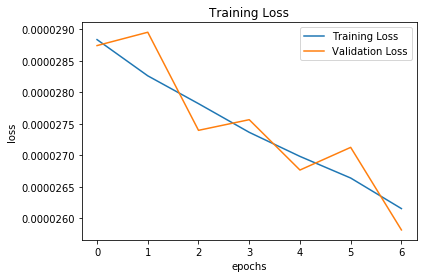

In [27]:
f1 = plt.figure()
ax = f1.add_subplot(111)
ax.plot(train_losses[1:], label="Training Loss")
ax.plot(val_losses[1:], label="Validation Loss")
ax.legend()
ax.set_title("Training Loss")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
f1.savefig("training_losses.png")

### Test Network

In [28]:
test_losses, testing_results = test(1)

### can be removed
with open('test_results.npz', 'wb') as f:
    np.savez(f, results = testing_results)

Test Epoch:  0 [ 0 / 8689 ] 	Loss:  2.2545220417669043e-05
Test Epoch:  0 [ 1024 / 8689 ] 	Loss:  2.2980293579166755e-05
Test Epoch:  0 [ 2048 / 8689 ] 	Loss:  2.357387165830005e-05
Test Epoch:  0 [ 3072 / 8689 ] 	Loss:  2.409341323073022e-05
Test Epoch:  0 [ 4096 / 8689 ] 	Loss:  2.314772063982673e-05
Test Epoch:  0 [ 5120 / 8689 ] 	Loss:  2.2332562366500497e-05
Test Epoch:  0 [ 6144 / 8689 ] 	Loss:  2.212718754890375e-05
Test Epoch:  0 [ 7168 / 8689 ] 	Loss:  2.107146974594798e-05
Test Epoch:  0 [ 3976 / 8689 ] 	Loss:  4.285695387324097e-05
Test Epoch:  0 	Average Loss:  2.3884977212859345e-05


In [29]:
### can be removed
testing_results = np.load('test_results.npz')['results']
print(testing_results.shape)

(8689, 112, 256)


### Process Testing Results

#### Create Split Indices
Finds indices on which to split the testing results data, in order to make sure that all the sound chunks belonging to a speech sample are in the same array.

In [30]:
split_indices = func.create_split_indices(testing_noisy_dir_chunks)  

#### Convert Spectrograms Back To Sound
Convert all the spectrograms that are created by the network back to sound fragments.

In [31]:
audio = func.spec_to_sound(testing_results)

#### Split Data
Splits the data on the indices previously computed.

In [32]:
sound_chunks = np.split(audio, split_indices)

#### Save Sound Fragmets
Appends all sound chunks belonging to a speech sample and saves them in a directory.

In [33]:
func.save_sound_to_dir(sound_chunks, new_rate, testing_noisy_dir, testing_results_dir)

### CI simulator

#### Compute Frequency Ranges

In [5]:
nr_channels = 22
freq_ranges = freqs.compute_frequency_ranges(nr_channels)

#### Create Simulated Data
Creates simulated data for both the original noisy data, as well as the data generated by the network.

In [8]:
samples = 15
func.convert_to_sim_data(testing_noisy_dir, testing_noisy_dir_simulated, freq_ranges, samples)
func.convert_to_sim_data(testing_results_dir, testing_results_dir_simulated, freq_ranges, samples)